In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image

In [4]:
data_dir = "../data"
damage_dir = os.path.join(data_dir, "damage")
no_damage_dir = os.path.join(data_dir, "no_damage")

print(f"Damage images: {len(os.listdir(damage_dir))}")
print(f"No-damage images: {len(os.listdir(no_damage_dir))}")

Damage images: 14170
No-damage images: 7152


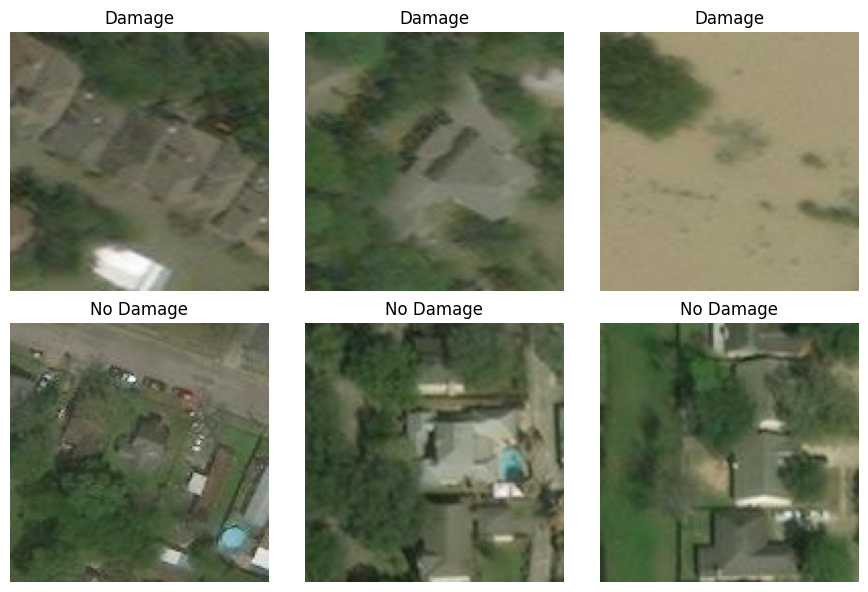

In [5]:
import random
sample_damage = random.sample(os.listdir(damage_dir), 3)
sample_no_damage = random.sample(os.listdir(no_damage_dir), 3)

fig, axes = plt.subplots(2, 3, figsize=(9, 6))
for i, img_name in enumerate(sample_damage):
    img = Image.open(os.path.join(damage_dir, img_name))
    axes[0, i].imshow(img)
    axes[0, i].set_title("Damage")
    axes[0, i].axis("off")

for i, img_name in enumerate(sample_no_damage):
    img = Image.open(os.path.join(no_damage_dir, img_name))
    axes[1, i].imshow(img)
    axes[1, i].set_title("No Damage")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

In [6]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training"
)

val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation"
)

Found 17058 images belonging to 2 classes.
Found 4264 images belonging to 2 classes.


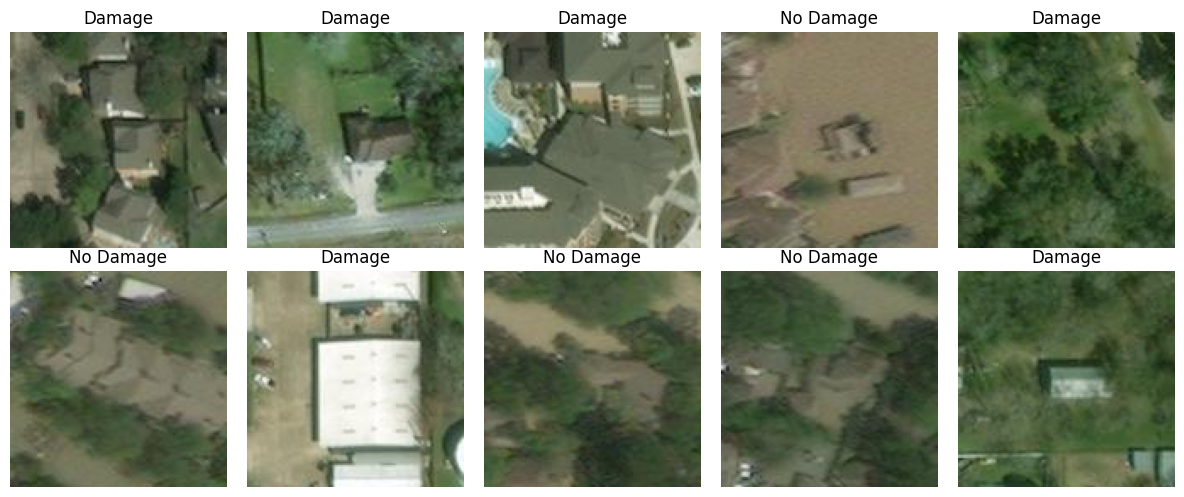

In [7]:
imgs, labels = next(train_gen)
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(imgs[i])
    ax.set_title("Damage" if labels[i] == 1 else "No Damage")
    ax.axis("off")
plt.tight_layout()
plt.show()

## Part 2 — Model Design, Training, and Evaluation

In [8]:
IMG_SIZE = (128, 128)
INPUT_SHAPE = (128, 128, 3)
EPOCHS = 10

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
ann = Sequential([
    Flatten(input_shape=INPUT_SHAPE),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

ann.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 256)               12583168  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 12616193 (48.13 MB)
Trainable params: 12616193 (48.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
history_ann = ann.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)

Epoch 1/10
534/534 [==============================] - 53s 97ms/step - loss: 0.6638 - accuracy: 0.6477 - val_loss: 0.6260 - val_accuracy: 0.6646
Epoch 2/10
534/534 [==============================] - 42s 79ms/step - loss: 0.6161 - accuracy: 0.6868 - val_loss: 0.5927 - val_accuracy: 0.6982
Epoch 3/10
534/534 [==============================] - 42s 79ms/step - loss: 0.5949 - accuracy: 0.6988 - val_loss: 0.5851 - val_accuracy: 0.7038
Epoch 4/10
534/534 [==============================] - 46s 86ms/step - loss: 0.5941 - accuracy: 0.7132 - val_loss: 0.5810 - val_accuracy: 0.6998
Epoch 5/10
534/534 [==============================] - 41s 78ms/step - loss: 0.5830 - accuracy: 0.7168 - val_loss: 0.5979 - val_accuracy: 0.6897
Epoch 6/10
534/534 [==============================] - 42s 79ms/step - loss: 0.6022 - accuracy: 0.6860 - val_loss: 0.6245 - val_accuracy: 0.6646
Epoch 7/10
534/534 [==============================] - 44s 82ms/step - loss: 0.6108 - accuracy: 0.6646 - val_loss: 0.6062 - val_accuracy:

In [12]:
val_loss, val_acc = ann.evaluate(val_gen)
print(f"Validation accuracy: {val_acc:.4f}")

134/134 [==============================] - 2s 13ms/step - loss: 0.5810 - accuracy: 0.6998
Validation accuracy: 0.6998


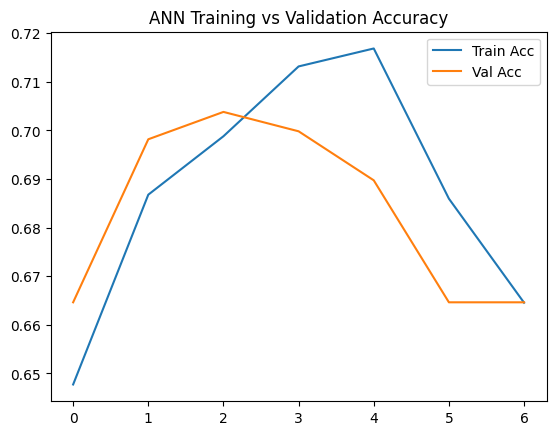

In [13]:
plt.plot(history_ann.history['accuracy'], label='Train Acc')
plt.plot(history_ann.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("ANN Training vs Validation Accuracy")
plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 6)       456       
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 29, 29, 16)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 13456)             0         
                                                                 
 dense_3 (Dense)             (None, 120)              

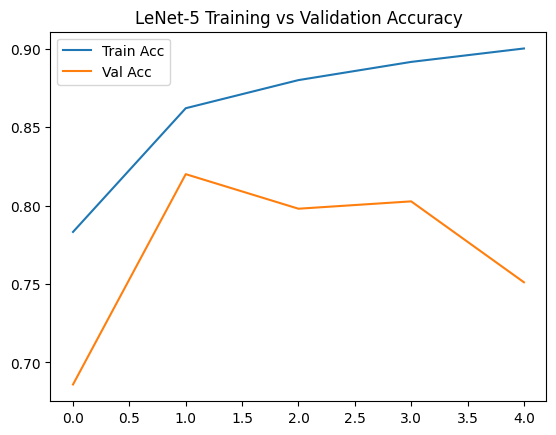

In [14]:
# --- LeNet-5 CNN ---
lenet = Sequential([
    Conv2D(6, (5,5), activation='relu', input_shape=INPUT_SHAPE),
    MaxPooling2D((2,2)),
    Conv2D(16, (5,5), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(1, activation='sigmoid')
])

lenet.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
lenet.summary()

history_lenet = lenet.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)

val_loss, val_acc = lenet.evaluate(val_gen)
print(f"Validation accuracy (LeNet-5): {val_acc:.4f}")

plt.plot(history_lenet.history['accuracy'], label='Train Acc')
plt.plot(history_lenet.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("LeNet-5 Training vs Validation Accuracy")
plt.show()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 flatten_2 (Flatten)         (None, 100352)           

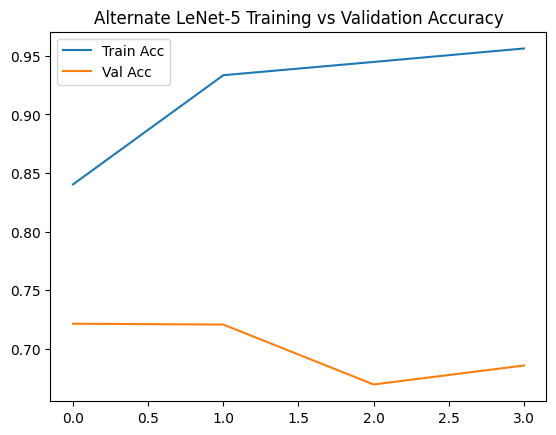

In [15]:
# --- Alternate LeNet-5 CNN (based on paper architecture) ---

alt_lenet = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=INPUT_SHAPE),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(1, activation='sigmoid')
])

alt_lenet.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
alt_lenet.summary()

history_alt = alt_lenet.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)

val_loss, val_acc = alt_lenet.evaluate(val_gen)
print(f"Validation accuracy (Alternate LeNet-5): {val_acc:.4f}")

plt.plot(history_alt.history['accuracy'], label='Train Acc')
plt.plot(history_alt.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Alternate LeNet-5 Training vs Validation Accuracy")
plt.show()

In [17]:
# Compare validation accuracies
val_scores = {
    "ANN": history_ann.history['val_accuracy'][-1],
    "LeNet-5": history_lenet.history['val_accuracy'][-1],
    "Alt LeNet-5": history_alt.history['val_accuracy'][-1]
}
print("Validation Accuracy Comparison:")
for k, v in val_scores.items():
    print(f"{k}: {v:.4f}")

# Pick best model
best_model_name = max(val_scores, key=val_scores.get)
print(f"\nBest model: {best_model_name}")

# Save it for deployment
if best_model_name == "ANN":
    ann.save("../results/best_model.h5")
elif best_model_name == "LeNet-5":
    lenet.save("../results/best_model.h5")
else:
    alt_lenet.save("../results/best_model.h5")

print("✅ Best model saved to results/best_model.h5")

Validation Accuracy Comparison:
ANN: 0.6646
LeNet-5: 0.7512
Alt LeNet-5: 0.6857

Best model: LeNet-5
✅ Best model saved to results/best_model.h5


/usr/local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
